In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycorn import pc_uni6
from scipy.optimize import curve_fit
from glob import glob
from scipy.stats import gaussian_kde

In [2]:
def parse_file(file):
    # from Ryan Kibler
    
    #loads the zipped files and parses the xml to collect the data. Returns a pandas dataframe
    fdata = pc_uni6(file)
    fdata.load()
    fdata.xml_parse()
    fdata.clean_up()

    #print(fdata.keys())
    #print(fdata['UV 1_280'])

    return pd.DataFrame().from_dict({key:fdata[key]['data'] for key in fdata.keys()},orient='index').transpose()

def eqm_binding(conc, K_D, high):
    return high*conc/(conc + K_D)

def eqm_binding_complex(conc_protein,conc_peptide,low,high,K_D):
    KDsum = conc_protein + conc_peptide + K_D
    f_bound = (KDsum - np.sqrt((KDsum)**2 - 4*conc_protein*conc_peptide))/(2*conc_peptide)
    return low + f_bound*(high-low)

# fig 1

Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data


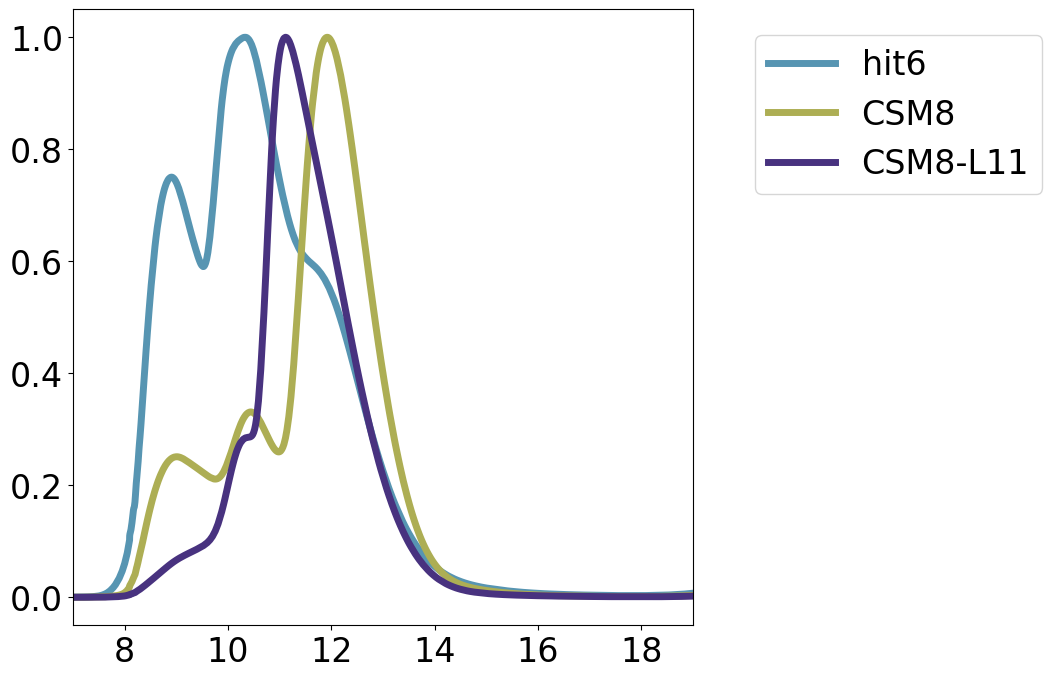

In [48]:
plt.figure(figsize=[8,8])

hit6 = parse_file('../figure1_library-screen/akta_traces/hit6_IPTG.zip')
hit6_uv = np.array(list(hit6['UV 1_280']))

CSM8 = parse_file('../figure1_library-screen/akta_traces/hit6_CSM8_IPTG.zip')
CSM8_uv = np.array(list(CSM8['UV 1_280']))

L11 = parse_file('../figure1_library-screen/akta_traces/hit6_CSM8_L11_IPTG.zip')
L11_uv = np.array(list(L11['UV 1_280']))

plt.plot(hit6_uv[:,0],hit6_uv[:,1]/np.max(hit6_uv[:,1]),linewidth=5,color='#5795B2',label='hit6')
plt.plot(CSM8_uv[:,0],CSM8_uv[:,1]/np.max(CSM8_uv[:,1]),linewidth=5,color='#ADAE54',label='CSM8')
plt.plot(L11_uv[:,0],L11_uv[:,1]/np.max(L11_uv[:,1]),linewidth=5,color='#48327F',label='CSM8-L11')
plt.xlim([7,19])
# plt.ylim([-10,670])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc=[1.1,0.7],fontsize=24)

plt.savefig('IPTG_akta_overlay.png',dpi=300,bbox_inches='tight')

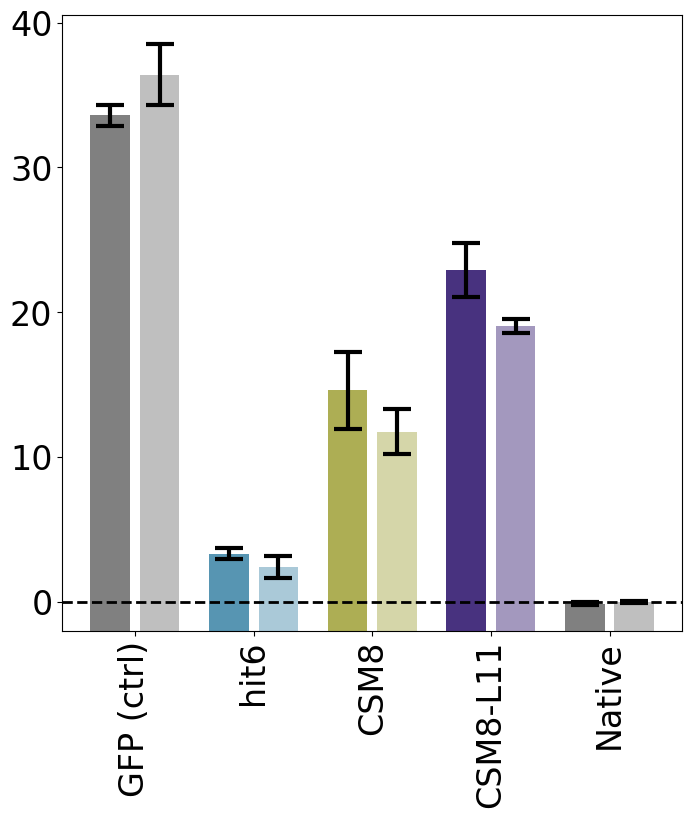

In [46]:
CFPS = pd.read_csv('../figure1_library-screen/20221216_CFPS_from_Laura/20221216_CFPS_from_Laura_with_hit6.csv',index_col=0)

names = {
    'sfGFP':'GFP (ctrl)',
    '(-) wt single chain dimer':'Native',
    'hit6':'hit6',
    'hit6_CSM8':'CSM8',
    'CSM8_normal_11_NT':'CSM8-L11'
}

colors = ['gray','#5795B2','#ADAE54','#48327F','gray']

plt.figure(figsize=[8,8])
ticks = []
tick_locs = []
for i,design in enumerate([1,13,3,11,2]):
    
    plt.bar(2.4*i + 1,CFPS.loc[design,'Soluble (uM)']+2,bottom=-2,color=colors[i],alpha=0.5,
            yerr=CFPS.loc[design,'Soluble std.1'],capsize=10,error_kw={'elinewidth':3,'capthick':3})
    
    plt.bar(2.4*i,CFPS.loc[design,'Total Ave (uM)']+2,bottom=-2,color=colors[i],
            yerr=CFPS.loc[design,'Total std.1'],capsize=10,error_kw={'elinewidth':3,'capthick':3})
    
    ticks.append(names[CFPS.loc[design,'Sample ID']])
    tick_locs.append(2.4*i + 0.5)
    
plt.xticks(tick_locs,ticks,rotation=90,fontsize=24)
plt.yticks([0,10,20,30,40],fontsize=24)
xlim = plt.xlim()
plt.plot(xlim,[0,0],'k--',linewidth=2)
plt.xlim(xlim)
plt.savefig('CFPS.png',dpi=300,bbox_inches='tight')

# fig 2

/var/folders/1r/_dnhk2ss6m3fr8s3lgl4kcmw0000gn/T/ipykernel_4360/524751826.py:20: RuntimeWarning: invalid value encountered in sqrt
  f_bound = (KDsum - np.sqrt((KDsum)**2 - 4*conc_protein*conc_peptide))/(2*conc_peptide)
/var/folders/1r/_dnhk2ss6m3fr8s3lgl4kcmw0000gn/T/ipykernel_4360/524751826.py:20: RuntimeWarning: invalid value encountered in sqrt
  f_bound = (KDsum - np.sqrt((KDsum)**2 - 4*conc_protein*conc_peptide))/(2*conc_peptide)


0 [2.37246420e+02 4.13535716e+02 3.80506552e-01]
1 [2.44303370e+02 4.17337703e+02 1.89411660e-01]


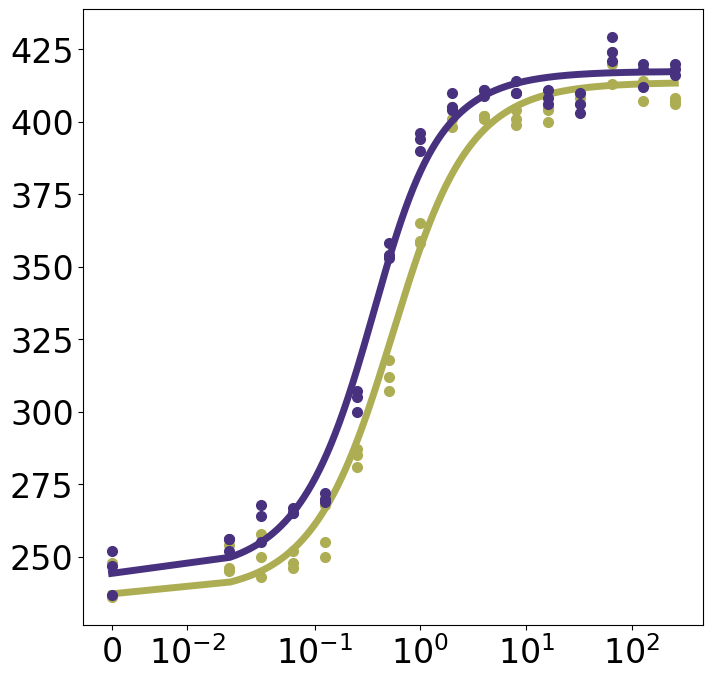

In [7]:
plt.figure(figsize=[8,8])

concs = [256/(2**i) for i in range(15)] + [0]

files = ['../figure2_H2Db-characterization-xtal/20250722_Laura_FP/CSM8_FPv2.csv',
         '../figure2_H2Db-characterization-xtal/20250722_Laura_FP/CSM8-L11_FPv2.csv']
colors = ['#ADAE54','#48327F']
names = ['CSM8','CSM8-L11']
for i in range(2):

    data = pd.read_csv(files[i],index_col=0)
    data = np.concatenate([data.loc['A':'C',:].values,data.loc['D':'F',:'4'].values],axis=1).T
    
    params,_ = curve_fit(lambda x,a,b,c: eqm_binding_complex(x,0.3,a,b,c),
                         np.tile(concs,[3,1]).T.flatten(),data.flatten(),p0=[80,250,concs[8]])
    
    x_fit = np.concatenate([[0],
                        np.logspace(np.log10(0.5*concs[-2]),np.log10(concs[0]),1000)],axis=0)
    y_fit = eqm_binding_complex(x_fit,0.3,*params)
    plt.plot(x_fit,y_fit,'-',linewidth=5,color=colors[i],label=names[i])
    plt.plot(concs,data,'o',markersize=7,color=colors[i])

    print(i,params)

plt.xscale('symlog',linthresh=concs[-2])
# plt.legend(loc=[0.025,0.8],fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(f'FITC-gp33_binding.png',dpi=300,bbox_inches='tight')

# fig 3

Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.498'}
added - orig data
added - orig data
added - orig data
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.498'}
added - orig data
added - orig data
added - orig data


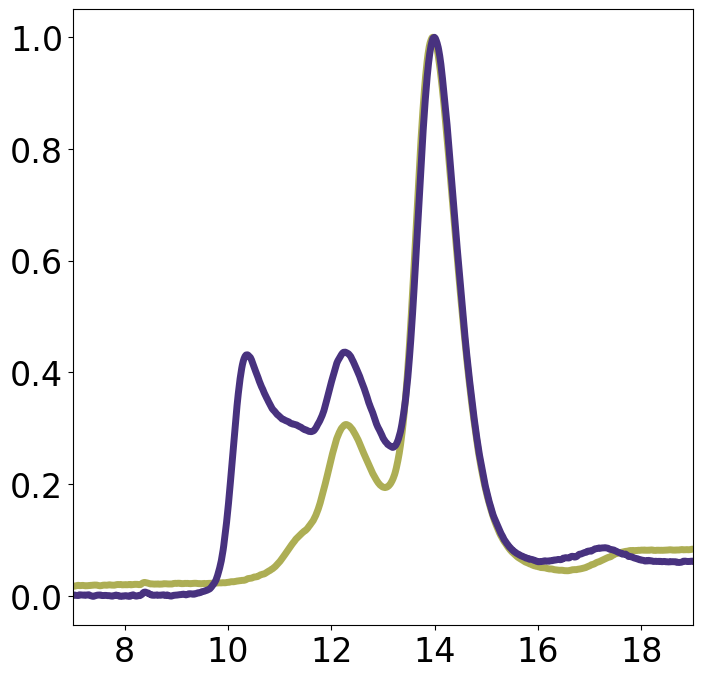

In [9]:
files = ['../figure3_A02-characterization-yeast/20250815_Laura_FP_SEC/A02_CSM8_monomer.zip',
         '../figure3_A02-characterization-yeast/20250815_Laura_FP_SEC/A02_SMART_monomer.zip']
colors = ['#ADAE54','#48327F','red']
names = ['CSM8','CSM8-L11']

plt.figure(figsize=[8,8])

for f,file in enumerate(files):
    A02 = parse_file(file)
    A02_uv = np.array(list(A02['UV 1_280']))
    
    plt.plot(A02_uv[:,0],A02_uv[:,1]/max(A02_uv[:,1]),linewidth=5,color=colors[f],label=names[f])
plt.xlim([7,19])
# plt.ylim([-10,670])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.legend(loc=[0.025,0.8],fontsize=24)

plt.savefig('A02_SEC_rerun.png',dpi=300,bbox_inches='tight')

0 [  113.72629668   416.807859   16090.63666854]
1 [ 113.09668504  393.3300439  7052.21053007]


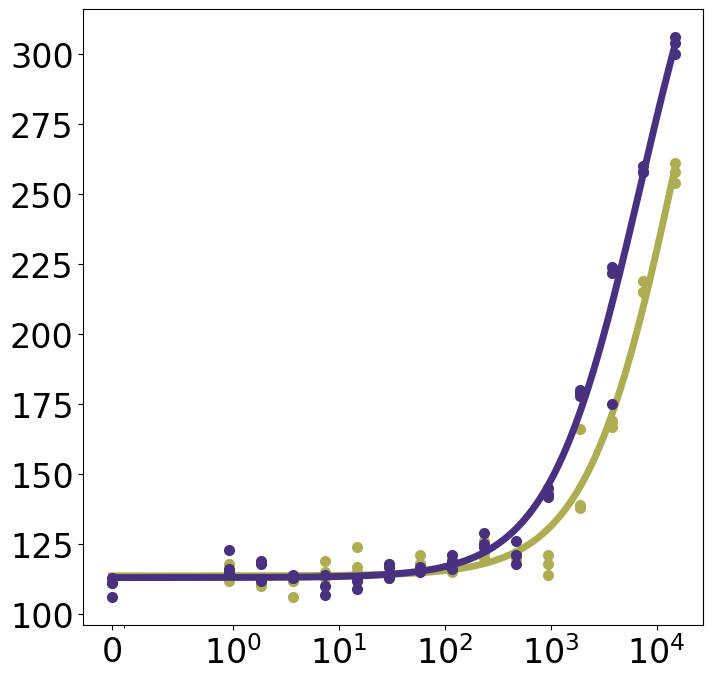

In [10]:
concs = [15000*(1/2)**i for i in range(15)] + [0]

plt.figure(figsize=[8,8])

files = ['../figure3_A02-characterization-yeast/20250815_Laura_FP_SEC/20250815_A02_CSM8_polarization.csv',
         '../figure3_A02-characterization-yeast/20250815_Laura_FP_SEC/20250815_A02_SMART_polarization.csv']
colors = ['#ADAE54','#48327F']
names = ['CSM8','CSM8-L11']
for i in range(2):

    data = pd.read_csv(files[i],index_col=0)
    data = np.concatenate([data.loc['A':'C',:].values,data.loc['D':'F',:'4'].values],axis=1).T
    
    params,_ = curve_fit(lambda x,a,b,c: eqm_binding_complex(x,10,a,b,c),
                         np.tile(concs,[3,1]).T.flatten(),data.flatten(),p0=[80,250,concs[8]])
    
    x_fit = np.concatenate([[0],
                        np.logspace(np.log10(0.5*concs[-2]),np.log10(concs[0]),1000)],axis=0)
    y_fit = eqm_binding_complex(x_fit,10,*params)
    plt.plot(x_fit,y_fit,'-',linewidth=5,color=colors[i],label=names[i])
    plt.plot(concs,data,'o',markersize=7,color=colors[i])

    print(i,params)

plt.xscale('symlog',linthresh=concs[-2])
# plt.legend(loc=[0.025,0.8],fontsize=24)
plt.yticks(fontsize=24)
plt.xticks([0,1,10,100,1000,1e4],fontsize=24)
plt.savefig(f'AF488-NYESO_binding.png',dpi=300,bbox_inches='tight')

In [24]:
def read_code(code):
    files = glob(f'../figure3_A02-characterization-yeast/20250806_Tina_A02_yeast_display/single_cells/export_{code}*_Single Cells.csv')
    assert len(files) == 1
    data = pd.read_csv(files[0])
    return data

2.992992992992993


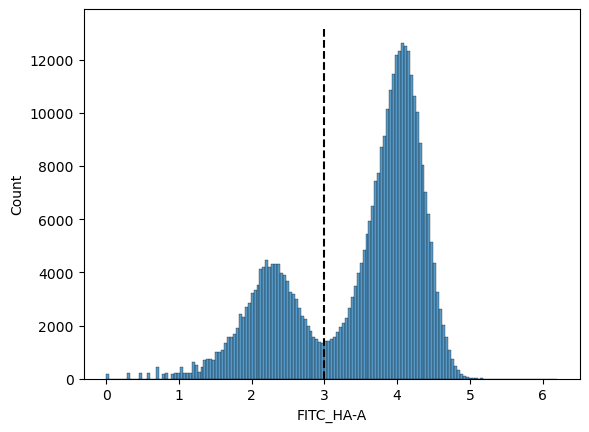

In [26]:
rows = {
    'A':'TCR (A6c134)',
    'B':'TCR (ctrl)',
    'C':'anti-A02',
    'D':'SA (ctrl)'
}

cols = {
    'hit6':[1,2,3],
    'CSM8':[7,8,9],
    'CSM8-L11':[4,5,6],
    'SCT':[10,11,12]
}

#get cutoff
expr = pd.concat([read_code(f'{row}{str(col).zfill(2)}')[['FITC_HA-A']] for row in rows for name in cols for col in cols[name]],axis=0)
expr = expr[expr['FITC_HA-A']>0]
kde = gaussian_kde(np.log10(expr.values.flatten()))
x_kde = np.linspace(2,4,1000)
y_kde = kde.pdf(x_kde)
cutoff = x_kde[y_kde==min(y_kde)][0]
print(cutoff)

sns.histplot(np.log10(expr['FITC_HA-A']))
plt.plot([cutoff]*2,plt.ylim(),'k--')

In [28]:
stain_name = {
    'A':'APC_A6c134tet-A',
    'B':'APC_S6Htet-A',
    'C':'APC_A2-A',
    'D':'APC_SA-A'
}
stain_cutoff = {}
for row in ['A','C']:
    tag_neg = []
    for name in cols:
        for col in cols[name]:
            code = f'{row}{str(col).zfill(2)}'
            data = read_code(code)
            tag_neg.append(data[np.log10(data['FITC_HA-A'])<=cutoff])
    tag_neg = pd.concat(tag_neg,axis=0)
    stain_cutoff[rows[row]] = np.quantile(tag_neg[stain_name[row]],0.99)
print(stain_cutoff)

{'TCR (A6c134)': 6969.800000000003, 'anti-A02': 3577.480000000003}


/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/basic/lib/python3.12/site-pack

In [32]:
cutoff_name = {
    'A':'TCR (A6c134)',
    'B':'TCR (A6c134)',
    'C':'anti-A02',
    'D':'TCR (A6c134)'
}

summary = []
for r,row in enumerate(rows):
    for c,name in enumerate(cols):
        for i,rep in enumerate(cols[name]):
            code = f'{row}{str(rep).zfill(2)}'
            data = read_code(code)
    
            tag_idx = data['FITC_HA-A']>10*cutoff
            frac_tag = np.mean(tag_idx)
            mean_tag = data.loc[tag_idx,'FITC_HA-A'].mean()/(10**cutoff)
    
            stain_idx = tag_idx & (data.loc[tag_idx,stain_name[row]]>stain_cutoff[cutoff_name[row]])
            frac_stain = np.sum(stain_idx)/np.sum(tag_idx)
            mean_stain = data.loc[stain_idx,stain_name[row]].mean()/stain_cutoff[cutoff_name[row]]
    
            summary.append([rows[row], name, i, frac_tag, mean_tag, frac_stain, mean_stain])
summary = pd.DataFrame(summary,columns=['stain', 'name', 'rep', 'frac_tag', 'mean_tag', 'frac_stain', 'mean_stain'])

summary

,stain,name,rep,frac_tag,mean_tag,frac_stain,mean_stain
0,TCR (A6c134),hit6,0,0.910561,13.849047,0.506862,2.230252
1,TCR (A6c134),hit6,1,0.936298,15.103031,0.424833,2.009384
2,TCR (A6c134),hit6,2,0.820260,12.731352,0.538718,2.331059
3,TCR (A6c134),CSM8,0,0.882011,9.677063,0.136730,1.267532
4,TCR (A6c134),CSM8,1,0.959523,10.883728,0.523917,2.181296
5,TCR (A6c134),CSM8,2,0.950083,9.574214,0.497317,1.929222
6,TCR (A6c134),CSM8-L11,0,0.933350,9.479686,0.499734,1.947706
7,TCR (A6c134),CSM8-L11,1,0.922525,7.979506,0.408891,1.574921
8,TCR (A6c134),CSM8-L11,2,0.965080,8.650573,0.509453,1.981654
9,TCR (A6c134),SCT,0,0.907442,6.981284,0.520947,1.635669


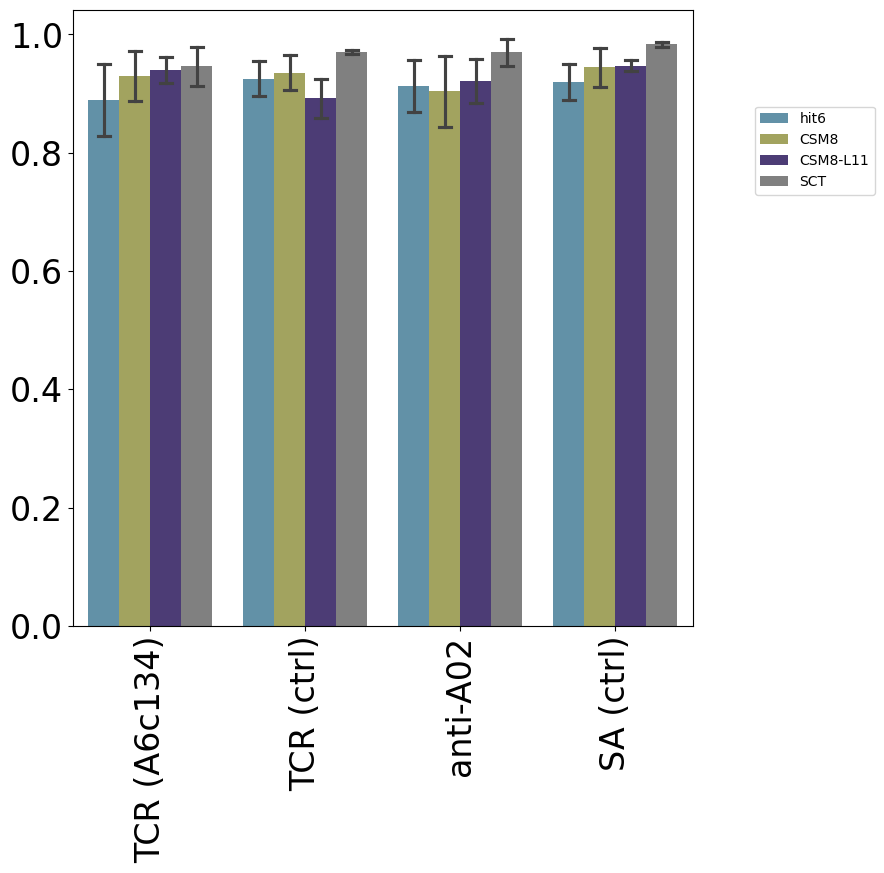

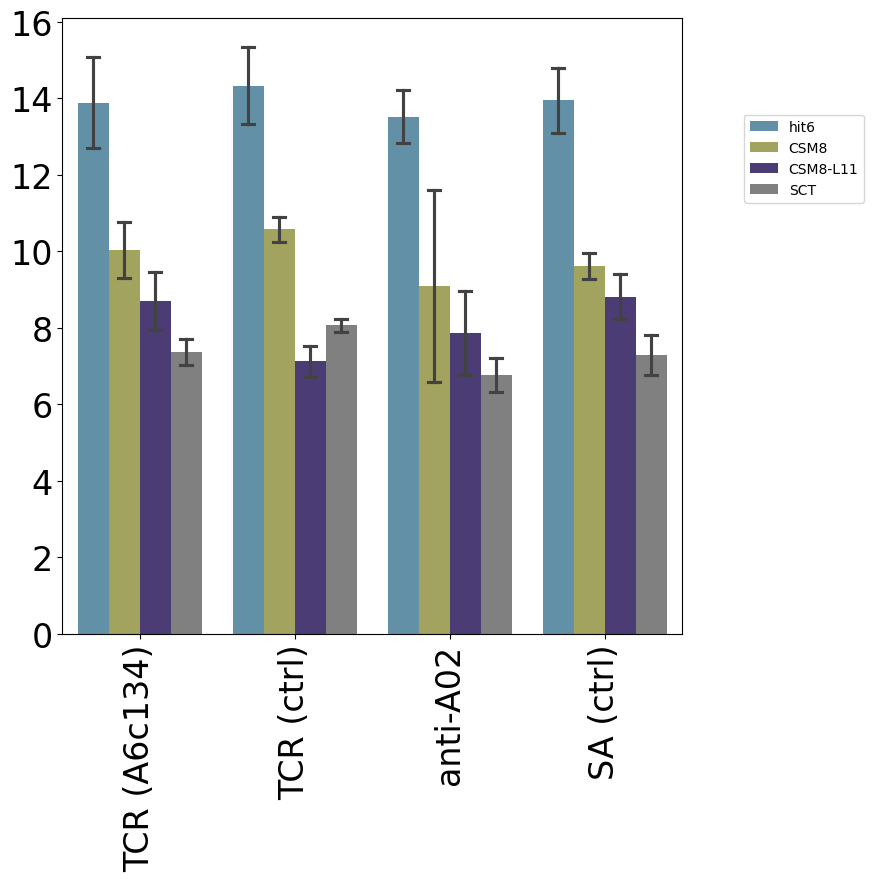

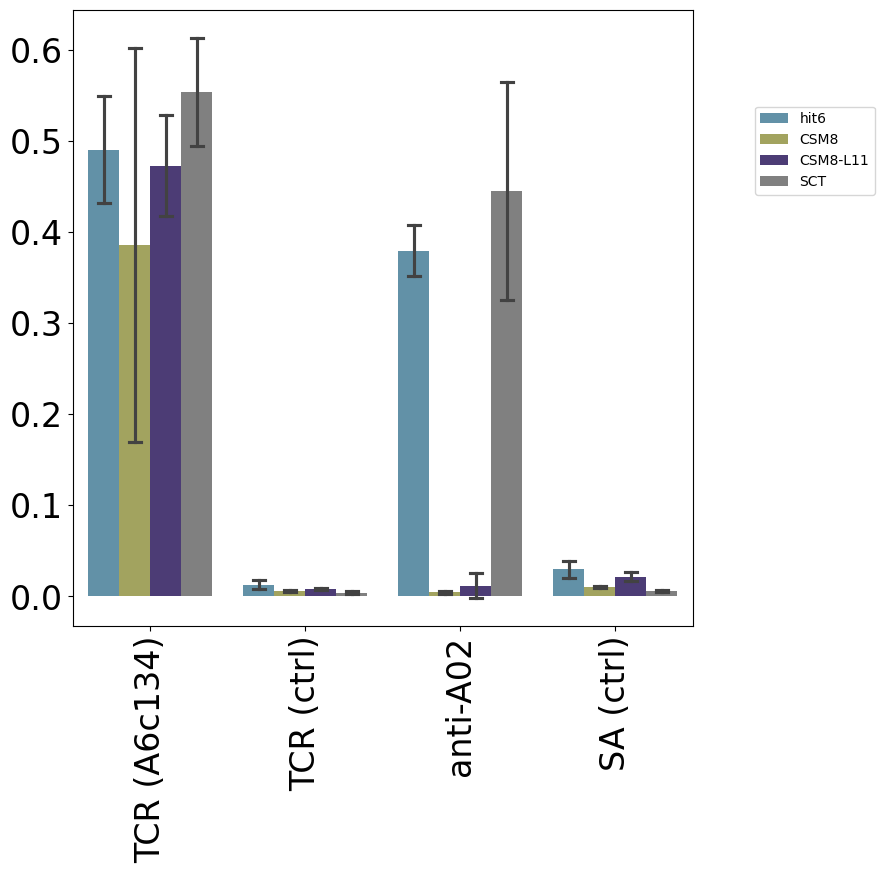

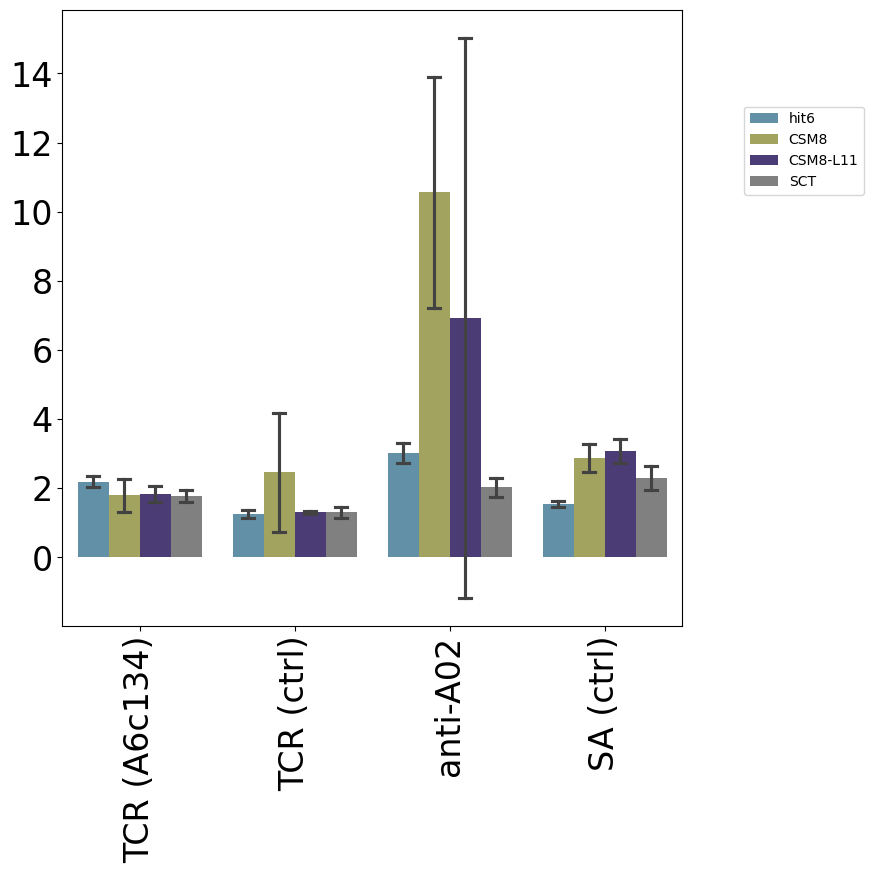

In [36]:
colors = {
    'hit6':'#5795B2',
    'CSM8':'#ADAE54',
    'CSM8-L11':'#48327F',
    'SCT':'gray'
}
alpha = [1,0.5]
for y in [col for col in summary.columns if '_' in col]:
    plt.figure(figsize=[8,8])

    sns.barplot(data=summary,x='stain',hue='name',y=y,palette=colors,
                errorbar=('sd',1),capsize=0.3)
    
    plt.xticks(fontsize=24,rotation=90)
    plt.yticks(fontsize=24)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(loc=[1.1,0.7])
    plt.savefig(f'yeast_display_{y}_barplot.png',dpi=300,bbox_inches='tight')

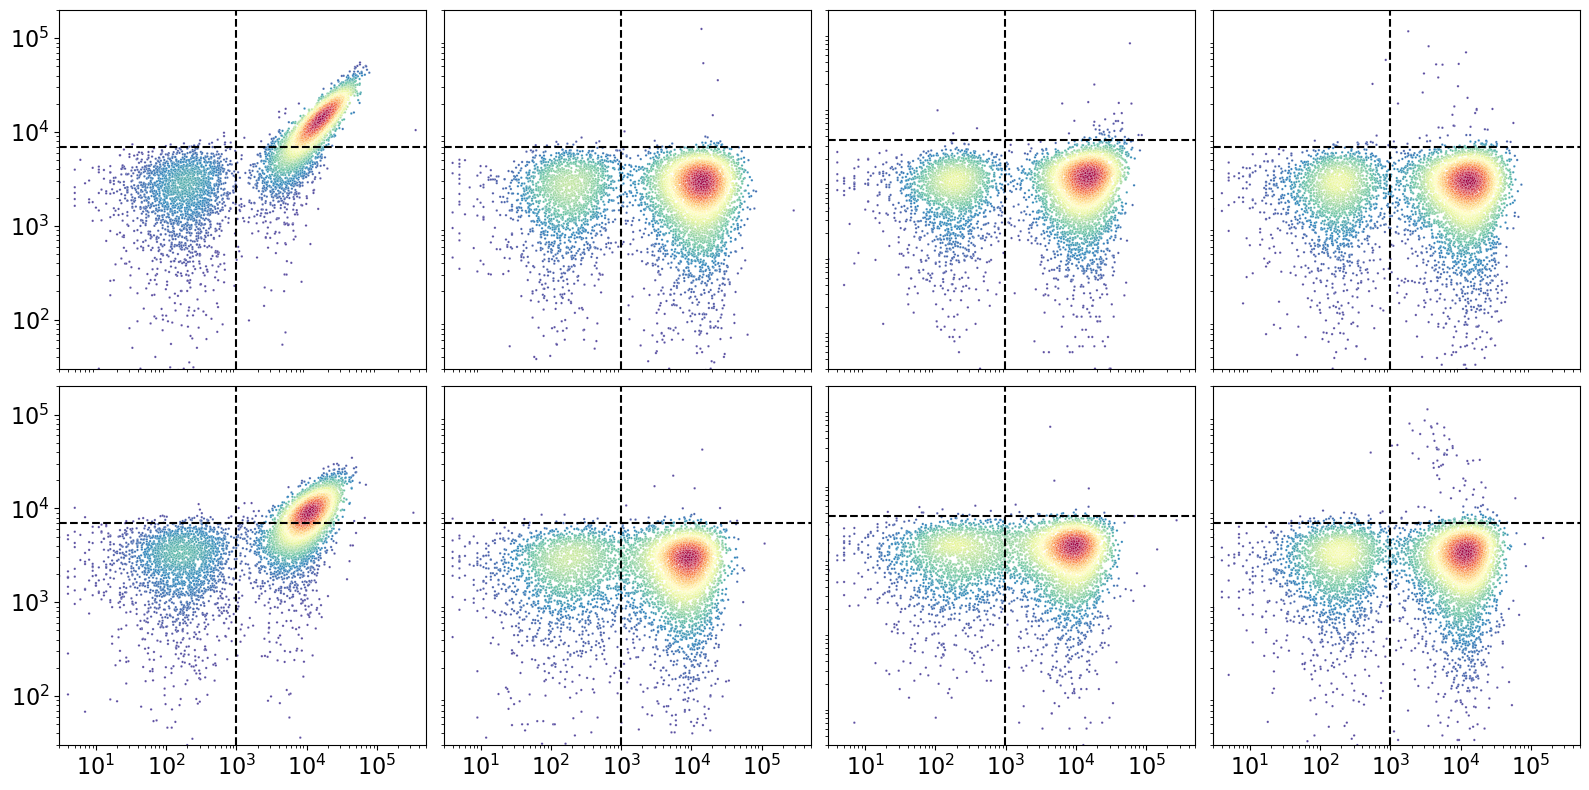

In [42]:
plt.figure(figsize=[16,8])
lims = {
    'TCR (A6c134)':[30,2e5],
    'anti-A02':[3,2e5]
}

cutoff_name = {
    'A':'TCR (A6c134)',
    'B':'TCR (A6c134)',
    'C':'anti-A02',
    'D':'TCR (A6c134)'
}
for r,row in enumerate(rows):
    for c,name in enumerate(['CSM8','CSM8-L11']):
        code = f'{row}{str(cols[name][1]).zfill(2)}'
        data = read_code(code)

        usable = data.loc[(data['FITC_HA-A']>0)&(data[stain_name[row]]>0),['FITC_HA-A',stain_name[row]]]
        kde = gaussian_kde(np.log10(usable.values.T))

        plt.subplot(2,4,r + 4*c + 1)
        sns.scatterplot(data=usable,
                        x='FITC_HA-A',
                        y=stain_name[row],
                        hue=kde.pdf(np.log10(usable.values.T)),
                        legend=None,
                        palette='Spectral_r',
                        s=3)

        plt.plot([3,5e5],[stain_cutoff[cutoff_name[row]]]*2,'k--')
        plt.plot([10**cutoff]*2,lims[cutoff_name[row]],'k--')

        plt.xlim([3,5e5])
        plt.ylim(lims[cutoff_name[row]])
        plt.loglog()

        plt.ylabel('')
        plt.xlabel('')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        # plt.text(6, 1.2e5, f'{rows[row]}, {name}',fontsize=12)

        if c!=1:
            plt.xticks([])
        if r!=0:
            plt.yticks([])
        
plt.tight_layout()
plt.savefig('example_flow_plots.png',dpi=300,bbox_inches='tight')